## 第零部分 初始化

In [1]:
# import packages
import pandas as pd
import numpy as np

# to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

# setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

# for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [4]:
# read the file
df = pd.read_csv('../res/input0130.csv')

# print the head
df.head()

,Unnamed: 0,date,close,log_r,label
0,0,2000-01-03,289.00,0.000000,0.0
1,1,2000-01-04,282.25,-0.023633,0.0
2,2,2000-01-05,280.00,-0.008004,0.0
3,3,2000-01-06,281.10,0.003921,1.0
4,4,2000-01-07,281.75,0.002310,1.0


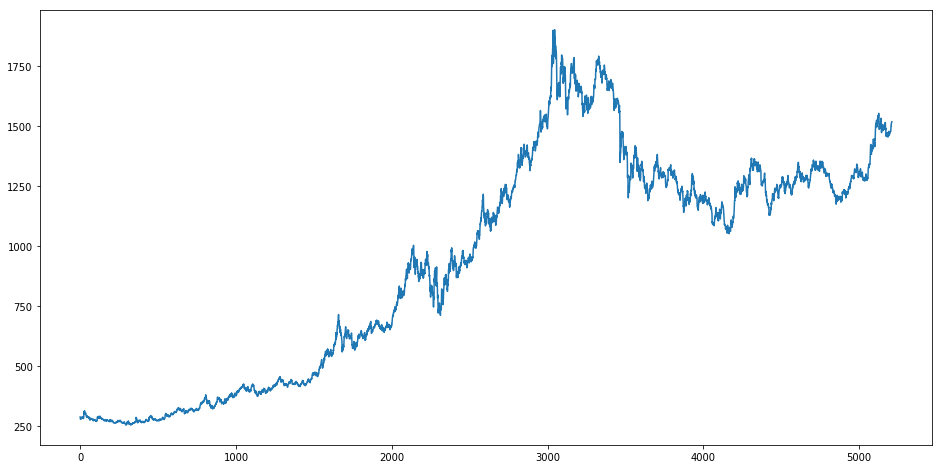

In [5]:
# setting index as date
# df['Ndate'] = pd.to_datetime(df.Ndate,format='%Y-%m-%d')
# df.index = df['Ndate']

# plot
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='Price History')

In [5]:
# splitting into train and validation
train = df[:5500].copy()
valid = df[5500:].copy()

df.shape, train.shape, valid.shape

((11039, 33), (5500, 33), (5539, 33))

## 第一部分 滑动平均

In [90]:
#make predictions
preds = []
for i in range(0,5539):
    a = train['xau'][len(train)-5539+i:].sum() + sum(preds)
    b = a/5539
    preds.append(b)
preds

[-0.001710422632785701,
 -0.001465017145627872,
 -0.0014384358322401902,
 -0.0014147990282741747,
 -0.0010771392348147548,
 -0.0007205519284841563,
 -0.0010683249349706131,
 -0.0012413698246501528,
 -0.0007676334398920105,
 -0.0007305540779927313,
 -0.0007462027747029666,
 -0.0007215042007319798,
 -0.000665634344837546,
 -0.0005751651394475546,
 -0.0007311749589347269,
 -0.0010391371038993298,
 -0.0010545792927608387,
 -0.0007627052424435903,
 -0.0007411343392557305,
 -0.0009479874171288582,
 -0.000911307794528593,
 -0.0009083980246774515,
 -0.0009177833415261026,
 -0.0009884897541170984,
 -0.001131965194585435,
 -0.0011473471960648692,
 -0.0012020884275499868,
 -0.0011082829260926025,
 -0.0008265303077365985,
 -0.0007709960694819922,
 -0.0006342927111265998,
 -0.0004366499804371481,
 -0.00023039742004365413,
 0.00019924136106845209,
 -5.530738523339062e-06,
 -0.00011510529922717067,
 1.061747901813945e-05,
 -9.583591320446065e-05,
 -2.172343024963206e-05,
 0.0039401203506800936,
 0.00

In [91]:
#calculate rmse
rms=np.sqrt(np.mean(np.power((np.array(valid['xau'])-preds),2)))
rms

1.004162729040933

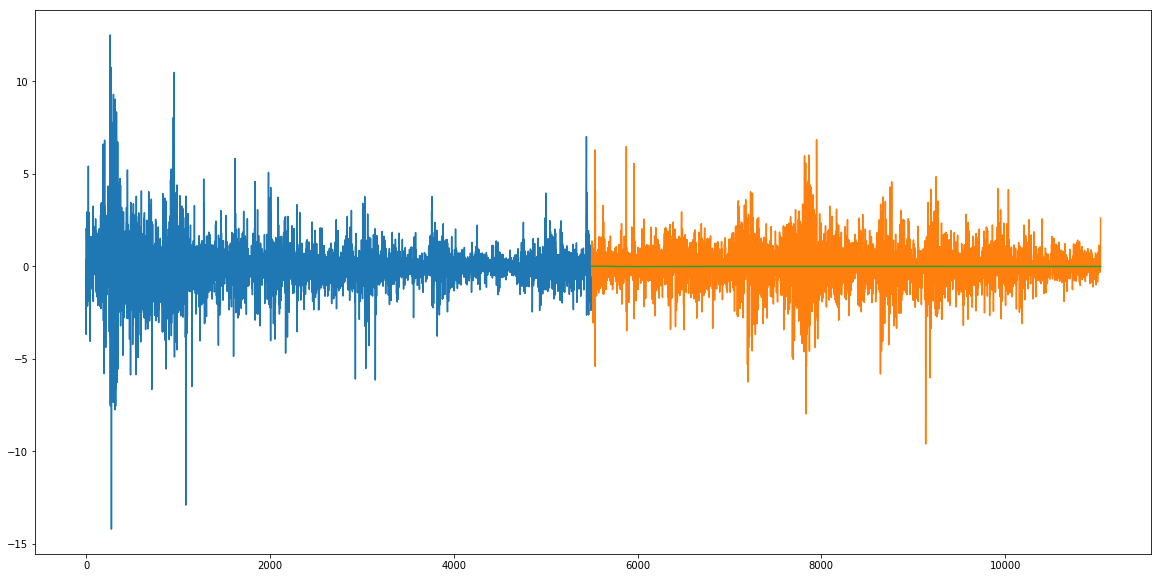

In [92]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['xau'])
plt.plot(valid[['xau', 'Predictions']])

## 第二部分 长短期记忆网络(LSTM)

In [2]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM 

Using TensorFlow backend.
C:\Users\hxh85\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hxh85\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hxh85\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hxh85\AppData\Roa

In [3]:
# read the file
df = pd.read_csv('../res/input0130.csv')

In [4]:
#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['close'])
for i in range(0,len(df)):
    new_data['close'][i] = df['close'][i]

In [5]:
#creating train and test sets
dataset = new_data.values
train = dataset[0:5500,:]
valid = dataset[5500:,:] 

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))

In [6]:
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = [], []

for i in range(25,len(train)):
    x_train.append(scaled_data[i-25:i,0])
    y_train.append(scaled_data[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) 

d:\visualstudio\shared\python36_64\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=25, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, batch_size=5, verbose=2)

W0304 10:49:23.435255  4012 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0304 10:49:23.458043  4012 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:508: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0304 10:49:23.463994  4012 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\backend\tensorflow_backend.py:3837: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0304 10:49:24.009100  4012 deprecation_wrapper.py:119] From d:\visualstudio\shared\python36_64\lib\site-packages\keras\optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0304 10:49:24.478811  4012 deprecation.

Epoch 1/3
 - 30s - loss: 0.0043
Epoch 2/3
 - 32s - loss: 2.9872e-04
Epoch 3/3
 - 28s - loss: 2.4412e-04


In [10]:
inputs

array([[0.72886519],
       [0.72976506],
       [0.73451979],
       [0.73372936],
       [0.74282535],
       [0.74106209],
       [0.74187684],
       [0.73242819],
       [0.73318214],
       [0.7349454 ],
       [0.74114113],
       [0.73816791],
       [0.74186468],
       [0.74205317],
       [0.74209573],
       [0.74157283],
       [0.74377995],
       [0.74320233],
       [0.74776248],
       [0.75622614],
       [0.75622614],
       [0.76326702],
       [0.76322446],
       [0.7656991 ],
       [0.76709755]])

In [9]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 25:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []

for i in range(25,inputs.shape[0]):
    X_test.append(inputs[i-25:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

IndexError: tuple index out of range

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

In [ ]:
#for plotting
rcParams['figure.figsize'] = 20,10
train = new_data[:5500].copy()
valid = new_data[5500:].copy()
valid['Predictions'] = closing_price
plt.plot(train['xau'])
plt.plot(valid[['xau','Predictions']])

In [ ]:
type(valid)

In [ ]:
valid.to_csv('LSTM_predict_v4.csv')

## 第三部分 神经网络

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
import keras as k
import os
 
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
df = pd.read_csv('res/model1117.csv')

In [18]:
df.head()

,lag1,lag2,lag3,cbv,ccu,cfi2z,clq,ctv,djci,dji,...,ngq,rbq,sp500,tyvix,usd,usu,zcu,zsq,zwu,Target
0,0.008947,-0.015993,0.001535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.004550,0.008947,-0.015993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,-0.004647,0.004550,0.008947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.001748,-0.004647,0.004550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,-0.006446,0.001748,-0.004647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [19]:
Y_PRED = []
Y_TEST = []
accuracy = []
precision = []
recall = []
f1 = []
df = df.reindex(np.random.permutation(df.index))
# 黄金价格涨跌放在最后一列，列名叫‘Target’，涨和不变记为1，跌记为0
x = df.iloc[:10000, :-1]
y = df.iloc[:10000, -1]

In [20]:
# 填参数的数目
num_parameters = 31

In [21]:
# 十折
sfolder = StratifiedKFold(n_splits=10, shuffle=True, random_state=1218)
all_y_test = []
for train, test in sfolder.split(x, y):
    batch_size = 128
    max_epochs = 64
    model = k.models.Sequential()
    # 每层神经元数可调
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True, input_shape=(num_parameters, )))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization(epsilon=1e-6))
    model.add(k.layers.Dense(units=256, activation='relu', use_bias=True))
    model.add(k.layers.normalization.BatchNormalization())
    model.add(k.layers.Dropout(0.5))
    model.add(k.layers.Dense(units=2, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    x_train = x.iloc[train.tolist(), :]
    y_train = y.iloc[train.tolist()]
    model.fit(x_train, np_utils.to_categorical(y_train, num_classes=2), batch_size=batch_size, epochs=max_epochs, shuffle=True, verbose=1)
    x_test = x.iloc[test.tolist(), :]
    y_test = y.iloc[test.tolist()]
    y_test = y_test.reset_index()['Target']
    y_pred = model.predict(x_test)
    test_0_num = 0
    test_0_pred_0 = 0
    test_1_num = 0
    test_1_pred_1 = 0
    for index in range(0, len(y_test)):
        if y_test[index] == 0:
            test_0_num = test_0_num + 1
            if y_pred[index][0] < 0.5:
                test_0_pred_0 = test_0_pred_0 + 1
        else:
            test_1_num = test_1_num + 1
            if y_pred[index][1] > 0.5:
                test_1_pred_1 = test_1_pred_1 + 1
    accuracy = accuracy + [(test_1_pred_1 + test_0_pred_0) / (test_0_num + test_1_num)]
    precision = precision + [test_1_pred_1 / (test_1_pred_1 + test_0_num - test_0_pred_0)]
    recall = recall + [test_1_pred_1 / (test_1_pred_1 + test_0_pred_0)]

7/64
9000/9000 [==============================] - 1s 92us/step - loss: 0.0781 - mae: 0.1514
Epoch 58/64
9000/9000 [==============================] - 1s 89us/step - loss: 0.0760 - mae: 0.1492
Epoch 59/64
9000/9000 [==============================] - 1s 93us/step - loss: 0.0751 - mae: 0.1496
Epoch 60/64
9000/9000 [==============================] - 1s 96us/step - loss: 0.0714 - mae: 0.1449
Epoch 61/64
9000/9000 [==============================] - 1s 91us/step - loss: 0.0732 - mae: 0.1444
Epoch 62/64
9000/9000 [==============================] - 1s 92us/step - loss: 0.0708 - mae: 0.1401
Epoch 63/64
9000/9000 [==============================] - 1s 95us/step - loss: 0.0717 - mae: 0.1420
Epoch 64/64
9000/9000 [==============================] - 1s 94us/step - loss: 0.0662 - mae: 0.1340
Epoch 1/64
9001/9001 [==============================] - 2s 192us/step - loss: 0.2967 - mae: 0.4583
Epoch 2/64
9001/9001 [==============================] - 1s 102us/step - loss: 0.2589 - mae: 0.4287
Epoch 3/64
9001/9

In [22]:
model.save('4NN.model')
[accuracy, precision, recall]

[[0.6053946053946054,
  0.5004995004995005,
  0.29270729270729273,
  0.447,
  0.534,
  0.596,
  0.451,
  0.5625625625625625,
  0.46346346346346345,
  0.6916916916916916],
 [0.583793738489871,
  0.48776223776223776,
  0.3099315068493151,
  0.44499178981937604,
  0.5174216027874564,
  0.5734767025089605,
  0.43859649122807015,
  0.5441176470588235,
  0.4543828264758497,
  0.667296786389414],
 [0.523102310231023,
  0.5568862275449101,
  0.6177474402730375,
  0.6062639821029083,
  0.5561797752808989,
  0.5369127516778524,
  0.49889135254988914,
  0.5266903914590747,
  0.5485961123110151,
  0.5108538350217077]]

In [28]:
y_output = []
y_1_num = 0
y_0_num = 0
for index in range(0, len(y_pred)):
        if y_pred[index][0] < 0.5:
            y_1_num = y_1_num + 1
            y_output.append(1)
        else:
            y_0_num = y_0_num + 1
            y_output.append(0)
y_1_num,y_0_num

(691, 308)

In [29]:
test_1_num,test_0_num

(485, 514)

In [30]:
y_pred

array([[0.99821496, 0.00178522],
       [0.04463664, 0.95549417],
       [0.6658752 , 0.33405697],
       ...,
       [0.02949107, 0.9704785 ],
       [0.22157261, 0.77687734],
       [0.26825163, 0.7315385 ]], dtype=float32)

In [26]:
comp_df = pd.DataFrame(y_test)
comp_df['Out'] = pd.DataFrame(y_output)
comp_df.to_csv('test_vs_out4.csv')

In [27]:
import keras as k

def ModelPredict(input):
    k.models.load_model('4NN.model')# 加载保存下来的模型
    return model.predict(input)# 直接用加载出来的模型，对输入 input 进行预测